## <center><font color="grey">Telecom Customer Churn Prediction</font><center>

<font color='black'>Customer attrition, also known as customer churn, is the loss of clients or customers.

Telephone service companies, Internet service providers, pay TV companies, insurance firms, and alarm monitoring services, often use customer attrition analysis and customer attrition rates as one of their key business metrics because the cost of retaining an existing customer is far less than acquiring a new one. Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients.

Companies usually make a distinction between voluntary churn and involuntary churn. Voluntary churn occurs due to a decision by the customer to switch to another company or service provider, involuntary churn occurs due to circumstances such as a customer's relocation to a long-term care facility, death, or the relocation to a distant location. In most applications, involuntary reasons for churn are excluded from the analytical models. Analysts tend to concentrate on voluntary churn, because it typically occurs due to factors of the company-customer relationship which companies control, such as how billing interactions are handled or how after-sales help is provided.

predictive analytics use churn prediction models that predict customer churn by assessing their propensity of risk to churn. Since these models generate a small prioritized list of potential defectors, they are effective at focusing customer retention marketing programs on the subset of the customer base who are most vulnerable to churn.</font>

In [14]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore")

## 1. Data

In [15]:
telecom = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
telecom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.1 Data Overview

In [16]:
print("Rows: " , telecom.shape[0])
print("Columns: ", telecom.shape[1])
print("Features: ", telecom.columns.values)
print("\nMissing values : " , telecom.isnull().sum().values.sum())
print("\nUnique values:\n", telecom.nunique())

Rows:  7043
Columns:  21
Features:  ['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']

Missing values :  0

Unique values:
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


## 2.Data Manipulation

In [17]:
#Data Manipulation

#remove rows with null totalcharges values
telecom['TotalCharges'] = telecom['TotalCharges'].replace(' ',np.nan)
telecom = telecom[telecom['TotalCharges'].notnull()].reset_index(drop=True)
#telecom = telecom.reset_index()[telecom.columns]
telecom['TotalCharges'] = telecom['TotalCharges'].astype(float)

#replace values to Yes or No
telecom['SeniorCitizen'] = telecom['SeniorCitizen'].replace({1:"Yes", 0:"No"})

columns_list = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']

#replace 'No internet service' to 'No' for columns_list
for col in columns_list:
    telecom[col] = telecom[col].replace({"No internet service":"No"})


def tenure_cat(telecom):
    if telecom['tenure'] <= 12:
        return "Tenure_1"
    elif telecom['tenure'] >12 and telecom['tenure'] <= 24 :
        return "Tenure_2"
    elif telecom['tenure'] >24 and telecom['tenure'] <= 36 :
        return "Tenure_3" 
    elif telecom['tenure'] >36 and telecom['tenure'] <= 48 :
        return "Tenure_4"
    elif telecom['tenure'] >48 and telecom['tenure'] <= 60 :
        return "Tenure_5"
    else :
        return "Tenure_6"
    
telecom['tenure_category'] = telecom.apply(lambda telecom: tenure_cat(telecom), axis=1)  

#Divide churn and not churn customers
churn = telecom[telecom['Churn']=='Yes']
not_churn = telecom[telecom['Churn']=='No']

#Separate categorical and numerical columns
id_col = ['customerID']
target = ['Churn']
cat_col = telecom.nunique()[telecom.nunique()<=6].index.tolist()
cat_col = [col for col in cat_col if col not in target]
num_col = [col for col in telecom if col not in id_col+target+cat_col]

telecom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_category
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_1
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_3
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_4
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_1


## 3. Exploratory data analysis

### 3.1 Customer attrition 

In [18]:
#labels
labels = telecom['Churn'].value_counts().keys().tolist()
#values
values = telecom['Churn'].value_counts().values.tolist()

trace = go.Pie(labels = labels,
               values = values,
               marker=dict(colors=['skyblue','royalblue'], 
                           line=dict(color='white', width=1.5)),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = 0.4
              )

layout = go.Layout(dict(title = "Customer Churn data",
                        paper_bgcolor = "rgb(243,243,243)"))

data = [trace]
figure = go.Figure(data = data, layout = layout)
py.iplot(figure)

### 3.2 Variables distribution in customer attrition

In [19]:
# function for pie plot for churn and not churn customers
def pie_plot(column):
    trace1 = go.Pie(labels = churn[column].value_counts().keys().tolist(),
                    values = churn[column].value_counts().values.tolist(),
                    hoverinfo = "label+value+name",
                    hole = 0.6,
                    domain = dict(x=[0,.48]),
                    marker= dict(line=dict(color='white', width=1.5)),
                    name = "Churn Customers")
    
    trace2 = go.Pie(labels = not_churn[column].value_counts().keys().tolist(),
                    values = not_churn[column].value_counts().values.tolist(),
                    hoverinfo = 'label+value+name',
                    name = "Non Churn Customers",
                    hole = 0.6,
                    domain = dict(x=[0.52,1]),
                    marker= dict(line=dict(color='white', width=1.5))
                    )
    
    layout = go.Layout(dict(title = column+" distribution in customer attrition",
                            plot_bgcolor = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size=12),
                                                showarrow = False,
                                                x = 0.17, y = 0.5),
                                           dict(text = "non churn customers",
                                                font = dict(size=12),
                                                showarrow = False,
                                                 x = 0.85, y = 0.5)]))
    data = [trace1,trace2]
    figure = go.Figure(data = data, layout = layout)
    py.iplot(figure)
    

# function for histogram plot for numerical column types
def hist_plot(column):
    trace1 = go.Histogram(x=churn[column],
                          histnorm = "percent",
                          name = "Churn customers",
                          marker = dict(line = dict(color="black", width=0.5)),
                          opacity = 0.9)
    
    trace2 = go.Histogram(x=not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(color="black", width=0.5)),
                          opacity = 0.9)
    
    layout = go.Layout(dict(title= column+" distribution in customer attrition",
                            plot_bgcolor = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2)))
    data = [trace1, trace2]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)


#function for scatter plot matrix for numerical columns in telecom
def scatter_matrix(df):
    
    classes = df['Churn'].unique().tolist()
    class_code = {classes[k] : k for k in range(len(classes))}
    color_vals = [class_code[val] for val in df['Churn']]
    
    pl_colorscale = "Portland"
    
    text = [df.loc[k,'Churn'] for k in range(len(df))]
    
    trace = go.Splom(dimensions = [dict(label='tenure', values=df['tenure']),
                                   dict(label = 'MonthlyCharges', values=df['MonthlyCharges']),
                                   dict(label = 'TotalCharges', values=df['TotalCharges'])],
                     text = text,
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),
                           ))
    
    data = [trace]
    fig = go.Figure(data = data, layout = layout)
    py.iplot(fig)

for col in num_col:
    hist_plot(col)
    
for col in cat_col:
    pie_plot(col)
    

scatter_matrix(telecom)    



### 3.3 Customer attrition in tenure category

In [20]:
ch_tc = churn['tenure_category'].value_counts().reset_index()
ch_tc.columns = ['tenure_category', 'count']

nonch_tc = not_churn['tenure_category'].value_counts().reset_index()
nonch_tc.columns = ['tenure_category', 'count']

trace1 = go.Bar(x=ch_tc['tenure_category'], y=ch_tc['count'],
                name = "Churn customers",
                marker = dict(line = dict(width=1.2, color='black')),
                opacity = 0.8)

trace2 = go.Bar(x=nonch_tc['tenure_category'], y=nonch_tc['count'],
                name  = 'Non churn customers',
                marker = dict(line = dict(width=1.2, color='black')),
                opacity = 0.8)

data = [trace1, trace2]

layout = go.Layout(dict(title='Customer attrition in tenure category'),
                        plot_bgcolor='rgb(243,243,243)',
                        paper_bgcolor='rgb(243,243,243)',
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "tenure category",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2)
                  )

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

### 3.4 Monthly charges and Total charges by Tenure and Churn category

In [21]:
#function for scatter plot of monthly and total charges by tenure category

def plot_tenure_cat(tenure_category, color):
        trace = go.Scatter(x = telecom[telecom['tenure_category']==tenure_category]['MonthlyCharges'],
                           y = telecom[telecom['tenure_category']==tenure_category]['TotalCharges'],
                           name = tenure_category,
                           mode = 'markers',
                           marker = dict( size = 4,
                                          color = color,
                                          line = dict(
                                          width = 0.2,
                                          color = 'black'
                                          ),
                                          symbol = 'diamond-dot'
                                           ),
                           opacity =0.9)
        return trace

#function for scatter plot of Monthly and Total charges by churn category
def plot_churn_cat(churn_data, color, name):
    trace = go.Scatter(x = churn_data['MonthlyCharges'],
                       y = churn_data['TotalCharges'],
                       name = name,
                       mode = 'markers',
                       marker = dict(size = 4,
                                      color = color,
                                      line = dict(
                                      width = 0.2,
                                      color = 'black'
                                       ),
                                      symbol = 'diamond-dot',
                                      opacity=0.9
                                     )
                      )
    return trace
    
trace1 = plot_tenure_cat("Tenure_1", 'green')
trace2 = plot_tenure_cat("Tenure_2", 'red')
trace3 = plot_tenure_cat("Tenure_3", 'blue')
trace4 = plot_tenure_cat("Tenure_4", 'pink')
trace5 = plot_tenure_cat("Tenure_5", 'grey')
trace6 = plot_tenure_cat("Tenure_6", 'skyblue')

trace7 = plot_churn_cat(churn,'purple',"Churn customers")
trace8 = plot_churn_cat(not_churn,'yellow',"Non churn customers")


data1 = [trace1,trace2,trace3,trace4,trace5,trace6]
data2 = [trace7, trace8]

def plot_layout(title):
    layout = go.Layout(dict(title=title,
                           plot_bgcolor="rgb(243,243,243)",
                           paper_bgcolor="rgb(243,243,243)",
                           xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Monthly charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "Total Charges",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                           ))
    return layout

layout1 = plot_layout("Monthly and Total charges by tenure category")
layout2 = plot_layout("Monthly and Total charges by churn category")

fig1 = go.Figure(data = data1, layout = layout1)
fig2 = go.Figure(data = data2, layout = layout2)

py.iplot(fig1)
py.iplot(fig2)

### 3.5 Average Monthly and Total charges by tenure group

In [22]:

avg_charge = telecom.groupby(['tenure_category','Churn'])[['MonthlyCharges','TotalCharges']].mean().reset_index()

#function to plot bar graph 
def plot_bar(column,churn_cat):
    trace = go.Bar(x = avg_charge[avg_charge['Churn']==churn_cat]['tenure_category'] ,
                   y = avg_charge[avg_charge['Churn']==churn_cat][column],
                   name = churn_cat,
                   text = "Churn"
                   )
    return trace

def plot_layout(title,ylabel):
    layout = go.Layout(dict(title=title,
                            plot_bgcolor = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Tenure category",
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = ylabel,
                                         zerolinewidth=1,ticklen=5,gridwidth=2))
                      )
    return layout

trace1 = plot_bar("MonthlyCharges","Yes")
trace2 = plot_bar("MonthlyCharges", "No")
trace3 = plot_bar("TotalCharges", "Yes")
trace4 = plot_bar("TotalCharges", "No")

data1 = [trace1, trace2]
data2 = [trace3,trace4]

layout1 = plot_layout("Average monthly charges by tenure category", "Monthly charges")
layout2 = plot_layout("Average total charges by tenure category", "Total charges")

fig1 = go.Figure(data = data1, layout=layout1)
fig2 = go.Figure(data = data2, layout=layout2)

py.iplot(fig1)
py.iplot(fig2)
    


### 3.7  Correlation matrix

In [23]:
correlation = telecom.corr()

col_list = correlation.columns.tolist()

array = np.array(correlation)

trace = go.Heatmap(z=array,
                   y=col_list,
                   x=col_list,
                   colorscale='Viridis',
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) 
                  )
layout = go.Layout(dict(title="Correlation Matrix",
                        autosize=False,
                        height=900,
                        width=900,
                       margin = dict(r=0,l=200,
                                     t=100, b=200)))
data=[trace]
fig = go.Figure(data = data, layout=layout)
py.iplot(fig)

## 4. Data Preprocessing

### 4.1 Feature Engineering

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#target column
print("Target column:\n" ,target)
#columns having categorical values
print("\nCategorical columns:\n",cat_col)
#columns having numerical values
print("\nNumerical column:\n",num_col)

#binary column having yes or no values
bin_col = telecom.nunique()[telecom.nunique()==2].keys().tolist()

multi_col = [col for col in cat_col if col not in bin_col]

laben = LabelEncoder()
for col in bin_col:
    telecom[col] = laben.fit_transform(telecom[col])

telecom = pd.get_dummies(data=telecom, columns=multi_col)

#normalizing the columns with numerical values
ss = StandardScaler()
scaled = ss.fit_transform(telecom[num_col])
scaled = pd.DataFrame(scaled, columns = num_col)

#storing the original dataframe
telecom_org = telecom.copy()
telecom = telecom.drop(columns=num_col,axis=1)
telecom = telecom.merge(scaled,left_index=True,right_index=True,how="left")
telecom.head()

Target column:
 ['Churn']

Categorical columns:
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_category']

Numerical column:
 ['tenure', 'MonthlyCharges', 'TotalCharges']


,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_Mailed check,tenure_category_Tenure_1,tenure_category_Tenure_2,tenure_category_Tenure_3,tenure_category_Tenure_4,tenure_category_Tenure_5,tenure_category_Tenure_6,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,1,0,0,0,1,1,0,1,0,...,1,0,0,1,0,0,0,0.064303,-0.260878,-0.173740
2,3668-QPYBK,1,0,0,0,1,1,1,0,0,...,1,1,0,0,0,0,0,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,1,0,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-1.239504,0.196178,-0.940457


### 4.2 Visualization using principal component analysis

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X = telecom[[col for col in telecom.columns if col not in target+id_col]]
Y = telecom[target + id_col]

pca_df = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_df,columns=["PC1","PC2"])
pca_df = pca_df.merge(Y,left_index=True,right_index=True,how="left")
pca_df['Churn'] = pca_df['Churn'].replace({1:"Churn",0:"Not Churn"})

def pca_scatter(target,color):
    
    trace = go.Scatter(x=pca_df[pca_df['Churn']==target]['PC1'],
                       y=pca_df[pca_df['Churn']==target]['PC2'],
                       name = target,
                       mode="markers",
                       marker = dict(line=dict(width=0.2),
                                     color = color,
                                     symbol='diamond-open',
                                     ),
                      text = ("Customer Id: " +  pca_df[pca_df['Churn']==target]['customerID']),
                      )
    return trace

def pca_layout():
    
    layout = go.Layout(dict(title="Visualization using Principal Component Analysis",
                            plot_bgcolor="rgb(243,243,243)",
                            paper_bgcolor="rgb(243,243,243)",
                            xaxis = dict(title="principal component 1"),
                            yaxis = dict(title="principal component 2"))
                      )
    return layout

trace1 = pca_scatter("Churn","red")
trace2 = pca_scatter("Not Churn", "royalblue")

data = [trace1, trace2]

layout = pca_layout()
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [27]:
summary = pd.DataFrame(telecom.describe().transpose())
summary

,count,mean,std,min,25%,50%,75%,max
gender,7032.0,5.046928e-01,0.500014,0.000000,0.000000,1.000000,1.000000,1.000000
SeniorCitizen,7032.0,1.624005e-01,0.368844,0.000000,0.000000,0.000000,0.000000,1.000000
Partner,7032.0,4.825085e-01,0.499729,0.000000,0.000000,0.000000,1.000000,1.000000
Dependents,7032.0,2.984926e-01,0.457629,0.000000,0.000000,0.000000,1.000000,1.000000
PhoneService,7032.0,9.032992e-01,0.295571,0.000000,1.000000,1.000000,1.000000,1.000000
OnlineSecurity,7032.0,2.865472e-01,0.452180,0.000000,0.000000,0.000000,1.000000,1.000000
OnlineBackup,7032.0,3.448521e-01,0.475354,0.000000,0.000000,0.000000,1.000000,1.000000
DeviceProtection,7032.0,3.438567e-01,0.475028,0.000000,0.000000,0.000000,1.000000,1.000000
TechSupport,7032.0,2.901024e-01,0.453842,0.000000,0.000000,0.000000,1.000000,1.000000
StreamingTV,7032.0,3.843857e-01,0.486484,0.000000,0.000000,0.000000,1.000000,1.000000


## 5. Model Build

### 5.1 Baseline Model

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score
from sklearn.metrics import roc_curve,roc_auc_score,scorer
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score


#split train and test data
train, test = train_test_split(telecom,test_size=0.25,random_state=4)
cols = [col for col in telecom.columns if col not in id_col+target]
train_X = train[cols]
train_Y = train[target]
test_X = test[cols]
test_Y = test[target]

#function to  fit and predict a given model along with metrics visualization
def telecom_churn_predict(model,train_X,train_Y,test_X,test_Y,cols,cf):
    model.fit(train_X,train_Y)
    predictions = model.predict(test_X)
    prob = model.predict_proba(test_X)
#     print(test_Y.shape)
#     print(predictions.shape)
#     print(prob.shape)

    if cf=="coefficients":
        coefficients = pd.DataFrame(model.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(model.feature_importances_)
        
    columns = pd.DataFrame(cols)
    coef_sumry = columns.merge(coefficients,left_index=True,right_index=True,how="left")
    coef_sumry.columns = ["features", "coefficients"]
    coef_sumry.sort_values(["coefficients"],ascending=False,inplace=True)
    
    print(model)
    print("\nClassification report :\n", classification_report(test_Y,predictions))
    print("\nAccuracy score : ", accuracy_score(test_Y,predictions))
    
    #Area under curve 
    roc_score = roc_auc_score(test_Y,predictions)
    print("\nROC score : ", roc_score, "\n")
    
    conf_matrix = confusion_matrix(test_Y,predictions)
    #print(conf_matrix)
    
    # roc curve 
    fpr, tpr,thresholds = roc_curve(test_Y,prob[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale=False,
                        colorscale="Picnic",
                        name="Confusion matrix"
                       )
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,
                        y = tpr,
                        name = "Roc : " + str(roc_score),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2)
                       )
    
    trace3 = go.Scatter(x=[0,1],
                        y=[0,1],
                        line = dict(color = ('rgb(200, 96, 167)'),width = 2)
                        )
    
    #plot features and coefficients
    trace4 = go.Bar(x = coef_sumry['features'],
                    y = coef_sumry['coefficients'],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Jet",
                                  line = dict(width = .6,color = "black")
                                 )
                   )
    
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    
    py.iplot(fig)
    
    
#Logistic regression model
logreg = LogisticRegression(C=1.0,solver='liblinear')
telecom_churn_predict(logreg,train_X,train_Y,test_X,test_Y,cols,"coefficients")


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Classification report :
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1263
           1       0.69      0.51      0.59       495

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.76      0.71      0.73      1758
weighted avg       0.79      0.80      0.79      1758


Accuracy score :  0.79806598407281

ROC score :  0.7114350152354904 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



### 5.2 Synthetic Minority Oversampling Technique

In [29]:
from imblearn.over_sampling import SMOTE

cols = [col for col in telecom.columns if col not in id_col+target]

smot_X = telecom[cols]
smot_Y = telecom[target]

train_smot_X,test_smot_X,train_smot_Y,test_smot_Y = train_test_split(smot_X,smot_Y,test_size=0.25,random_state=4)

smot = SMOTE(random_state=1)
os_train_X,os_train_Y = smot.fit_sample(train_smot_X,train_smot_Y)

os_train_X = pd.DataFrame(os_train_X,columns=cols)
os_train_Y = pd.DataFrame(os_train_Y,columns=target)

logr_smote = LogisticRegression(C=1.0,solver='liblinear')

telecom_churn_predict(logr_smote,os_train_X,os_train_Y,test_smot_X,test_smot_Y,cols,"coefficients")


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.74      0.81      1263
           1       0.54      0.78      0.64       495

   micro avg       0.75      0.75      0.75      1758
   macro avg       0.72      0.76      0.73      1758
weighted avg       0.80      0.75      0.76      1758


Accuracy score :  0.7525597269624573

ROC score :  0.7602269728160465 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



### 5.3 Recursive Feature Elimination

In [30]:
from sklearn.feature_selection import RFE

logreg = LogisticRegression(solver="liblinear")
rfe = RFE(logreg,10)
rfe = rfe.fit(os_train_X,os_train_Y)

rfe_df = pd.DataFrame({"Features":[col for col in telecom.columns if col not in id_col+target],
                       "Support":rfe.support_,
                       "Ranking":rfe.ranking_})

#selecting best 10 features
cols = rfe_df[rfe_df['Support']==True]['Features'].tolist()

train_rfe_X = os_train_X[cols]
train_rfe_Y  = os_train_Y
test_rfe_X  = test_X[cols]
test_rfe_Y = test_Y

log_rfe = LogisticRegression(C=1, solver="liblinear")
telecom_churn_predict(log_rfe,train_rfe_X,train_rfe_Y,test_rfe_X,test_rfe_Y,cols,"coefficients")

table = ff.create_table(rfe_df)
py.iplot(table)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1263
           1       0.53      0.79      0.63       495

   micro avg       0.74      0.74      0.74      1758
   macro avg       0.71      0.76      0.72      1758
weighted avg       0.79      0.74      0.75      1758


Accuracy score :  0.7428896473265074

ROC score :  0.7577964922382975 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



### 5.4 Univariate Selection

Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)

In [31]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

cols = [col for col in telecom_org.columns if col not in id_col+target]
chi_X = telecom_org[cols]
chi_Y =telecom_org[target]

select = SelectKBest(score_func=chi2,k=3)
fit = select.fit(chi_X,chi_Y)

print("chi2 scores:")
print(fit.scores_)
print("p values:")
print(fit.pvalues_)

chi_df = pd.DataFrame({"Feature":cols,
                       "Score":fit.scores_,
                       "pvalue":fit.pvalues_})
chi_df.sort_values("Score",ascending=False,inplace=True)

chi_df["Feature_Type"] = np.where(chi_df["Feature"].isin(num_col),"Numerical","Categorical" )

trace1 = go.Scatter(x=chi_df[chi_df["Feature_Type"]=="Categorical"]["Feature"],
                    y=chi_df[chi_df["Feature_Type"]=="Categorical"]["Score"],
                    name = "Categorical",
                    mode = "lines+markers",
                    marker = dict(line=dict(width=0.5),
                                  color = "green"),
                    xaxis="x1", yaxis="y1"
                   )

trace2 = go.Bar(x=chi_df[chi_df["Feature_Type"]=="Numerical"]["Feature"],
                    y=chi_df[chi_df["Feature_Type"]=="Numerical"]["Score"],
                    name = "Numerical",
                    marker = dict(color = "skyblue"),
                    xaxis = "x2", yaxis="y2"
                   )

layout = go.Layout(dict(title="Chi2 score for Categorical and Numerical Features",
                        plot_bgcolor= "rgb(243,243,243)",
                        paper_bgcolor="rgb(243,243,243)",
                         xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                    ))
                   

data = [trace1,trace2]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

chi2 scores:
[2.54297062e-01 1.33482766e+02 8.18577694e+01 1.31271509e+02
 1.63773281e+04 9.29483891e-02 1.47165601e+02 3.12098318e+01
 2.02160070e+01 1.35439602e+02 1.73206148e+01 1.59306111e+01
 1.04979224e+02 3.65307468e+03 6.29630810e+05 3.88864216e+00
 8.68247305e-01 6.51465136e+00 7.11376111e+01 3.72082851e+02
 2.85475152e+02 5.16714004e+02 1.76608724e+02 4.86223101e+02
 7.66190658e+01 9.99725387e+01 4.24113152e+02 4.47251434e+01
 4.96199796e+02 2.38616006e+00 1.04209180e+01 2.22562632e+01
 6.29955193e+01 2.87501128e+02]
p values:
[6.14065505e-001 7.08954608e-031 1.46240915e-019 2.15953960e-030
 0.00000000e+000 7.60461827e-001 7.21988253e-034 2.31590182e-008
 6.91717063e-006 2.64595220e-031 3.15742928e-005 6.57073922e-005
 1.23423173e-024 0.00000000e+000 0.00000000e+000 4.86137123e-002
 3.51440986e-001 1.06989295e-002 3.33158163e-017 6.58713045e-083
 4.81399951e-064 2.19511926e-114 2.66631661e-040 9.45428638e-108
 2.07328356e-018 1.54524820e-023 3.10584857e-094 2.26727030e-011
 6

### 5.5 Decision Tree Visualization

1. Using top three categorical features


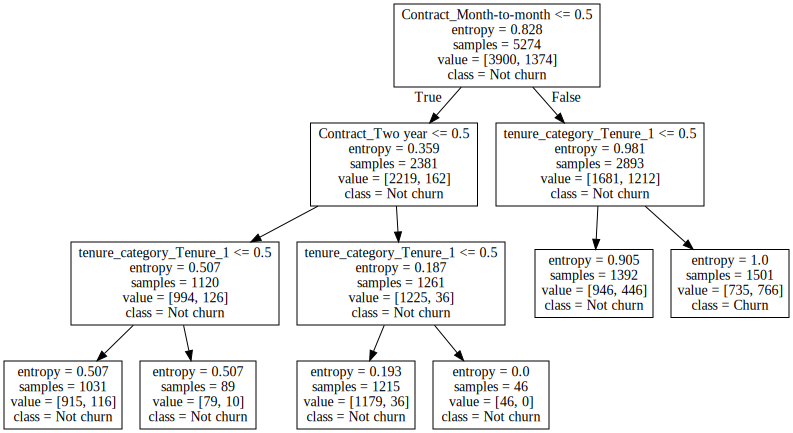

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=4,
            splitter='best')

Classification report :
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1263
           1       0.52      0.52      0.52       495

   micro avg       0.73      0.73      0.73      1758
   macro avg       0.67      0.67      0.67      1758
weighted avg       0.73      0.73      0.73      1758


Accuracy score :  0.7315130830489193

ROC score :  0.6675735982149283 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



In [32]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from graphviz import Source
from IPython.display import Image,display


feature_cat = chi_df[chi_df["Feature_Type"]=="Categorical"]["Feature"][0:3].tolist()
feature_num = chi_df[chi_df["Feature_Type"]=="Numerical"]["Feature"][0:3].tolist()

def plot_decision_tree(columns,max_depth,criterion,split_type,model_performance=None):
    
    #input consisting only top three features
    dtc_X = train_X[columns]
    dtc_Y = train_Y
    
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth,
                                           criterion=criterion,
                                           splitter=split_type,
                                           random_state=4)
    dt_classifier.fit(dtc_X,dtc_Y)
    
    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        feature_names=columns,
                                        class_names=["Not churn","Churn"])
                  )
    
    #display
    display(graph)
    
    if model_performance==True:
        telecom_churn_predict(dt_classifier,dtc_X,dtc_Y,test_X[columns],test_Y,columns,"features")
      
    
plot_decision_tree(feature_cat,3,"entropy","best",True)
        

2. Use top three numerical features

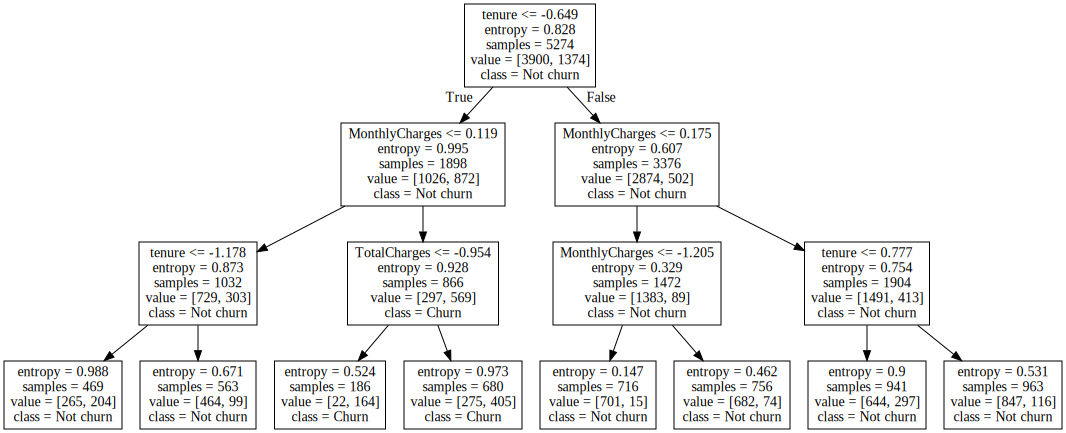

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=4,
            splitter='best')

Classification report :
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      1263
           1       0.64      0.37      0.47       495

   micro avg       0.76      0.76      0.76      1758
   macro avg       0.71      0.65      0.66      1758
weighted avg       0.75      0.76      0.74      1758


Accuracy score :  0.7639362912400455

ROC score :  0.6453009909066916 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



In [33]:
plot_decision_tree(feature_num,3,"entropy","best",True)

### 5.6 Random Forest 


#### 1.Visualizing a tree from random forest classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Classification report :
               precision    recall  f1-score   support

           0       0.77      0.96      0.86      1263
           1       0.72      0.28      0.41       495

   micro avg       0.77      0.77      0.77      1758
   macro avg       0.75      0.62      0.63      1758
weighted avg       0.76      0.77      0.73      1758


Accuracy score :  0.767349260523322

ROC score :  0.6206506873965306 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



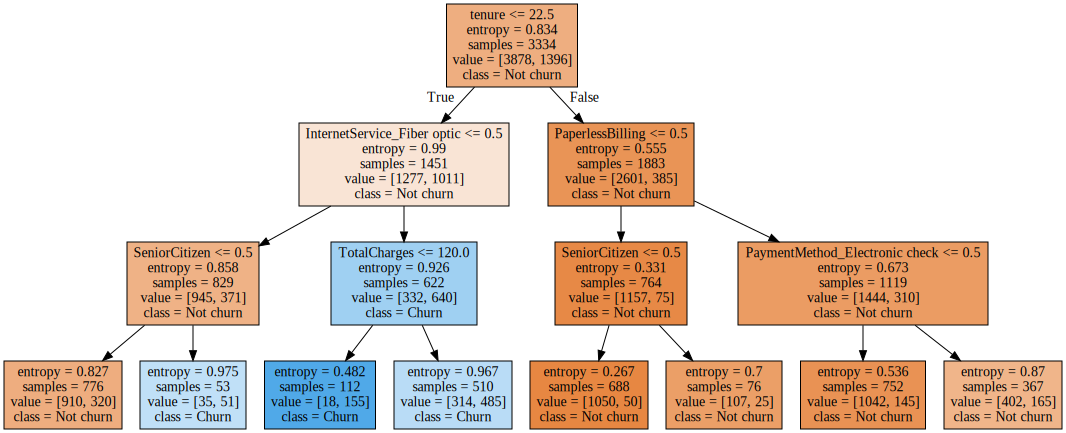

In [34]:
from sklearn.ensemble import RandomForestClassifier


def plot_randomforest_tree(columns,n_estimators,criterion,max_depth,estimated_tree,model_performance):
    
    #training and test data sets
    rfc_train,rfc_test = train_test_split(telecom_org,test_size=0.25,random_state=4)
    rfc_train_X = rfc_train[columns]
    rfc_train_Y = rfc_train[target]
    rfc_test_X = rfc_test[columns]
    rfc_test_Y = rfc_test[target]
    
    rfc = RandomForestClassifier(n_estimators = n_estimators,
                                 max_depth = max_depth,
                                 criterion = criterion)
    
    rfc.fit(rfc_train_X,rfc_train_Y)
    
    tree_ = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(tree_,out_file=None,
                                        feature_names=columns,
                                        class_names=["Not churn","Churn"],
                                        filled=True
                                                      )
                 )
                  
                   
    if model_performance==True :
        telecom_churn_predict(rfc,rfc_train_X,rfc_train_Y,rfc_test_X,rfc_test_Y,columns,"features")
     
    display(graph)
                   
cols = [col for col in telecom_org.columns if col not in id_col+target]
plot_randomforest_tree(cols,100,"entropy",3,89,True)

#### 2. Visualizing a random forest with 5 trees

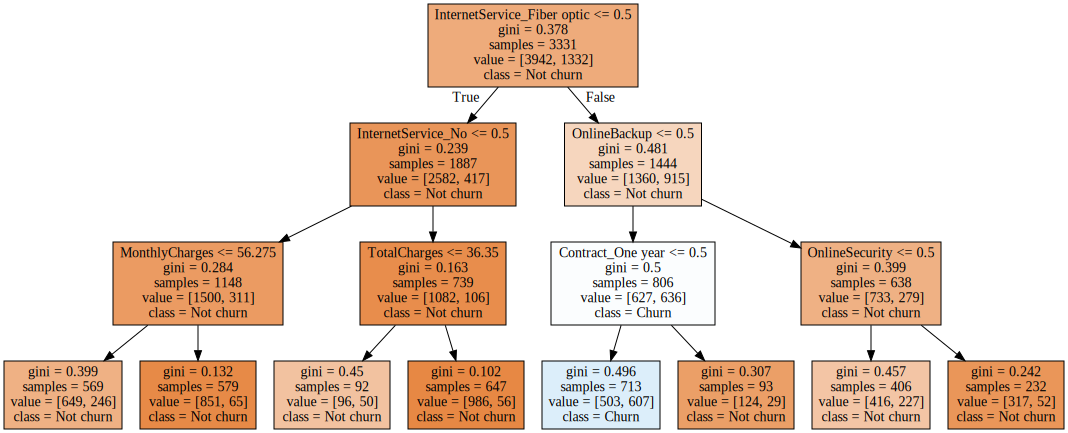

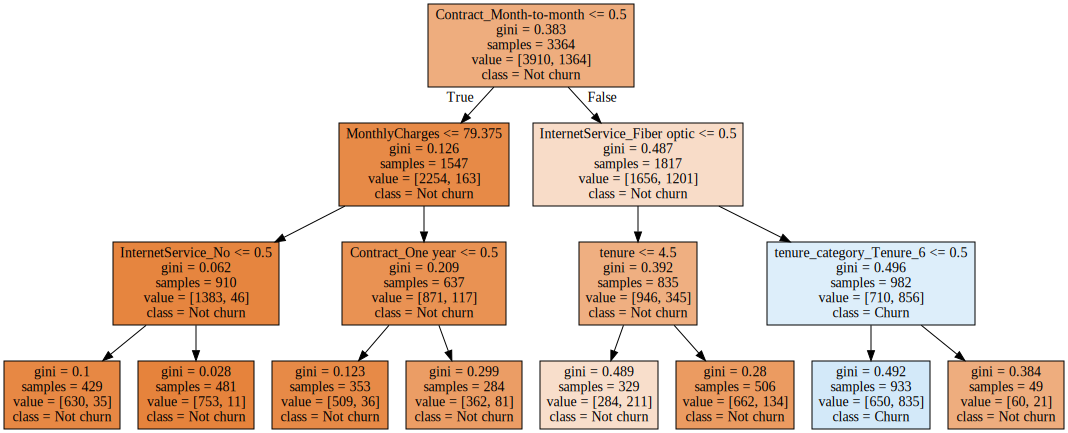

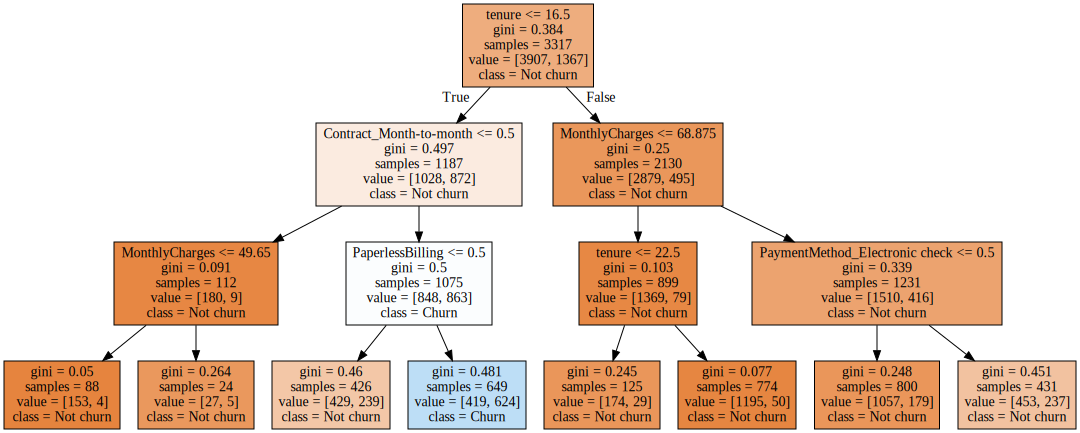

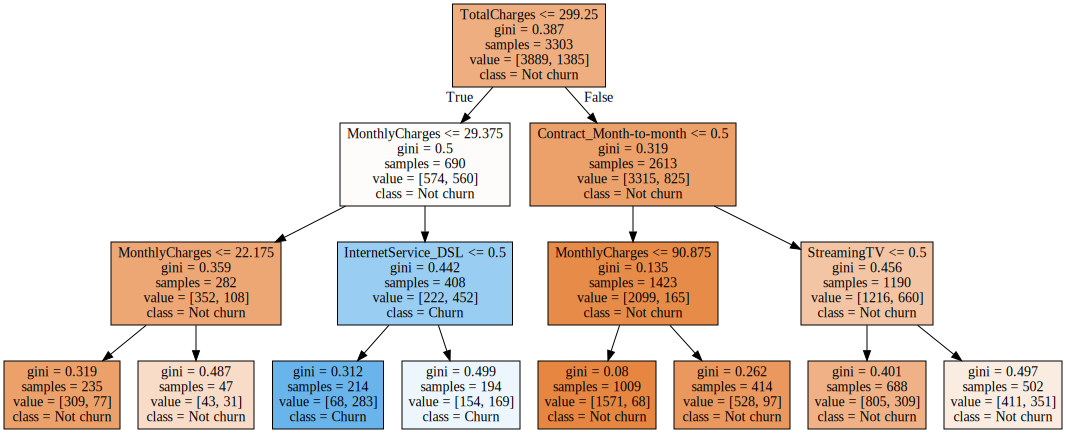

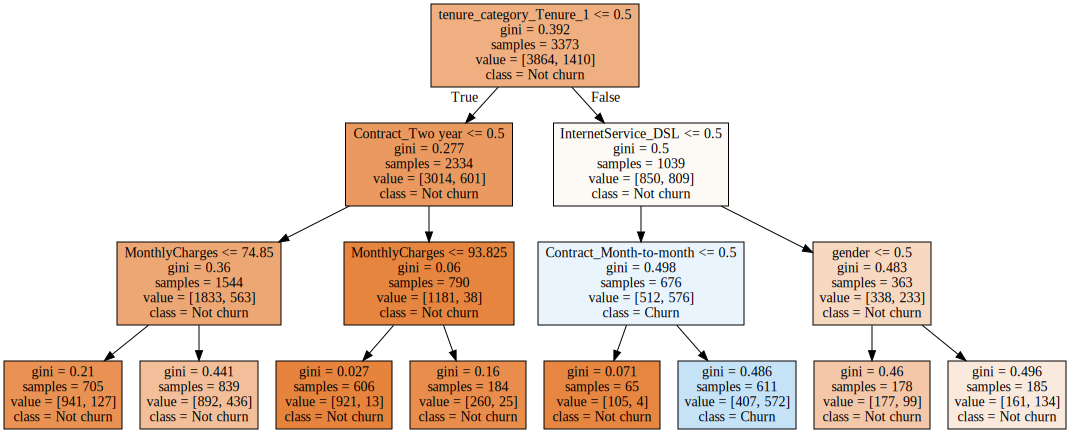

In [35]:

for i in range(1,6):
    plot_randomforest_tree(cols,100,"gini",3,i,False)

### 5.7 KNN classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier


def telecom_churn_prediction(model,train_X,train_Y,test_X,test_Y):
    
    model.fit(train_X,train_Y)
    predictions = model.predict(test_X)
    prob = model.predict_proba(test_X)
    
    print(model)
    #classification report
    print("Classification report:\n", classification_report(test_Y,predictions))
    
    #accuracy score
    print("\nAccuracy score : ", accuracy_score(test_Y,predictions))
    
    #roc score
    roc_score = roc_auc_score(test_Y,predictions)
    print("\nRoc score : ", roc_score)
    
    #confusion matrix
    conf_matrix = confusion_matrix(test_Y,predictions)
    
    #roc curve
    fpr, tpr, thresholds = roc_curve(test_Y,prob[:,1])
    
    trace1 = go.Scatter(x = fpr,
                        y = tpr,
                        name = "Roc: " + str(roc_score),
                        line = dict(color='rgb(50,90,150)', width=2)
                       )
    trace2 = go.Scatter(x=[0,1],
                        y=[0,1],
                        line = dict(color = "red", width=2,dash='dot'),
                       )
    
    trace3 = go.Heatmap(z= conf_matrix,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        name = "matrix",
                        colorscale = "Viridis",
                        showscale=False,
                        xaxis = "x2", yaxis="y2")
    
    layout = go.Layout(dict(title="Model performance" ,
                            autosize = False,height = 500,width = 800,
                            showlegend = False,
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(title = "false positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         domain=[0, 0.5],
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(title = "true positive rate",
                                         gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            margin = dict(b=200),
                            xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                        gridcolor = 'rgb(255,255, 255)'),
                            yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                           )
                  )
    data = [trace1,trace2,trace3]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)
    
    
kNN = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', 
                           leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)

telecom_churn_prediction(kNN,os_train_X,os_train_Y,test_X,test_Y)
    

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77      1263
           1       0.48      0.68      0.56       495

   micro avg       0.70      0.70      0.70      1758
   macro avg       0.66      0.69      0.67      1758
weighted avg       0.75      0.70      0.71      1758


Accuracy score :  0.699089874857793

Roc score :  0.6947599510544878


### 5.8 Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB(priors=None)

telecom_churn_prediction(gaussian,os_train_X,os_train_Y,test_X,test_Y)

GaussianNB(priors=None, var_smoothing=1e-09)
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80      1263
           1       0.52      0.80      0.63       495

   micro avg       0.74      0.74      0.74      1758
   macro avg       0.71      0.76      0.72      1758
weighted avg       0.80      0.74      0.75      1758


Accuracy score :  0.7389078498293515

Roc score :  0.7580964034645745


### 5.9 Support Vector Machine

In [38]:
from sklearn.svm import SVC

svm = SVC(C=1.0, kernel='linear', degree=3, gamma='auto_deprecated', coef0=0.0, shrinking=True,
          probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, 
          decision_function_shape='ovr', random_state=4)

cols = [col for col in telecom.columns if col not in id_col+target]

telecom_churn_predict(svm,os_train_X,os_train_Y,test_X,test_Y,cols,"coefficients")

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=4,
  shrinking=True, tol=0.001, verbose=False)

Classification report :
               precision    recall  f1-score   support

           0       0.90      0.73      0.80      1263
           1       0.53      0.79      0.64       495

   micro avg       0.75      0.75      0.75      1758
   macro avg       0.72      0.76      0.72      1758
weighted avg       0.80      0.75      0.76      1758


Accuracy score :  0.7457337883959044

ROC score :  0.7597759063317258 

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



## 6. Model Perfomance

### 6.1 Model performance metrics

In [39]:
from sklearn.metrics import f1_score

columns = ['Model','Accuracy','Precision','Recall','F1_score','Roc']
metrics_df = pd.DataFrame(columns=columns)

def model_metrics(model,train_X,train_Y,test_X,test_Y,name):
    
    
    model.fit(train_X,train_Y)
    predictions = model.predict(test_X)
    
    index = metrics_df.shape[0]
    metrics_df.loc[index,"Model"] = name
    metrics_df.loc[index,"Accuracy"] = round(accuracy_score(test_Y,predictions),3)
    metrics_df.loc[index,"Precision"] = round(precision_score(test_Y,predictions),3)
    metrics_df.loc[index,"Recall"] = round(recall_score(test_Y,predictions),3)
    metrics_df.loc[index,"F1_score"] = round(f1_score(test_Y,predictions),3)
    metrics_df.loc[index,"Roc"] = round(roc_auc_score(test_Y,predictions),3)
    
    
model_metrics(logreg,train_X,train_Y,test_X,test_Y,"LogisticRegression")
model_metrics(logr_smote,os_train_X,os_train_Y,test_X,test_Y,"LogisticRegression SMOTE")
model_metrics(log_rfe,train_rfe_X,train_rfe_Y,test_rfe_X,test_rfe_Y,"LogisticRegression RFE")

dt_classifier = DecisionTreeClassifier(max_depth=3,
                                       criterion = 'entropy',
                                       splitter="best",
                                       random_state=None
                                       )


model_metrics(dt_classifier,train_X,train_Y,test_X,test_Y,"Decision Tree")

rfc = RandomForestClassifier(n_estimators=10,
                             criterion = "gini",
                             max_depth = 3)

model_metrics(rfc,train_X,train_Y,test_X,test_Y,"Random Forest")

model_metrics(kNN,os_train_X,os_train_Y,test_X,test_Y,"kNearest Neighbors")
model_metrics(gaussian,os_train_X,os_train_Y,test_X,test_Y,"Gaussian Naive Bayes")
model_metrics(svm,os_train_X,os_train_Y,test_X,test_Y,"Support Vector Machine")

table = ff.create_table(metrics_df)
py.iplot(table)


### 6.2 Compare model metrics

In [40]:

def bar_plot_metrics(metric,color):
    trace = go.Bar(y=metrics_df["Model"],
                   x=metrics_df[metric],
                   orientation = 'h',
                   name = metric,
                   marker = dict(line = dict(width =1),
                                  color = color))
    return trace

layout = go.Layout(dict(title="Model Performances",
                        plot_bgcolor="rgb(243,243,243)",
                        paper_bgcolor ="rgb(243,243,243)",
                        showlegend=False,
                        height = 800,
                        
                        margin = dict(l=250)))

trace1 = bar_plot_metrics("Accuracy","orange")
trace2 = bar_plot_metrics("Precision","green")
trace3= bar_plot_metrics("Recall", "skyblue")
trace4 = bar_plot_metrics("F1_score","yellow")
trace5 = bar_plot_metrics("Roc","grey")

data=[trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)